In [1]:
! pip install pyconll

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! pip install pydot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
! pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
from numpy.random import seed
seed(1)
import tensorflow
#from tensorflow import set_random_seed
tensorflow.random.set_seed(2)
import pyconll, keras, gensim, pickle, os, random, nltk, datetime, warnings, gc, urllib.request, zipfile, collections
import numpy as np
import matplotlib.pyplot as plt
from gensim.models.keyedvectors import KeyedVectors
from gensim.models import FastText
from sklearn.utils import shuffle
from sklearn.metrics import recall_score, precision_score, classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV, learning_curve, cross_val_score
from sklearn import preprocessing
from sklearn.exceptions import UndefinedMetricWarning

from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, Input, LSTM, Bidirectional, GRU, TimeDistributed, concatenate,\
SpatialDropout1D, Layer, Lambda, BatchNormalization, Dropout, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.callbacks import Callback
from keras.models import load_model
from keras.utils import plot_model
from IPython.display import Image 
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

In [6]:
from keras.layers import Flatten, GlobalMaxPooling1D
from tensorflow.keras.layers import add
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling1D, MaxPooling2D
from keras import backend as K

In [7]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [8]:
def plot_confusion_matrix(f1,
                          cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          i=1):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    plt.figure(figsize=(10, 6))
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}; f1-score={:0.4f}'.format(accuracy, misclass, f1))

In [9]:
def plot_acc():
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [10]:
def plot_loss():
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

##Parameters

In [77]:
MAX_CHAR_LENGTH=3
MAX_SEQUENCE_LENGTH = 70
EMBEDDING_DIM = 300
#VALIDATION_SPLIT = 0.2
BATCH_SIZE = 32
EPOCHS = 20

##dataSET

In [12]:
TRAIN = '/content/drive/MyDrive/MArathi_data/mr_cmupan-ud-train.conllu'
DEV = '/content/drive/MyDrive/MArathi_data/mr_cmupan-ud-dev.conllu'
TEST = '/content/drive/MyDrive/MArathi_data/mr_cmupan-ud-test.conllu'

In [13]:
def read_conllu(path):
    data = pyconll.load_from_file(path)
    tagged_sentences=[]
    t=0
    for sentence in data:
        tagged_sentence=[]
        for token in sentence:
            if token.upos and token.form:
                t+=1
                tagged_sentence.append((token.form.lower(), token.upos))
        tagged_sentences.append(tagged_sentence)
    return tagged_sentences

In [14]:
train_sentences = read_conllu(TRAIN)
val_sentences = read_conllu(DEV)
test_sentences = read_conllu(TEST)

In [15]:
print("Tagged sentences in train set: ", len(train_sentences))
print("Tagged words in train set:", len([item for sublist in train_sentences for item in sublist]))
print(40*'=')
print("Tagged sentences in dev set: ", len(val_sentences))
print("Tagged words in dev set:", len([item for sublist in val_sentences for item in sublist]))
print(40*'=')
print("Tagged sentences in test set: ", len(test_sentences))
print("Tagged words in test set:", len([item for sublist in test_sentences for item in sublist]))
print(40*'*')
print("Total sentences in dataset:", len(train_sentences)+len(val_sentences)+len(test_sentences))

Tagged sentences in train set:  11518
Tagged words in train set: 163688
Tagged sentences in dev set:  1490
Tagged words in dev set: 20089
Tagged sentences in test set:  1503
Tagged words in test set: 21437
****************************************
Total sentences in dataset: 14511


In [16]:
print(train_sentences[0])

[('बार्लीची', 'PROPN'), ('वैरण', 'NOUN'), ('जनावरांसाठी', 'NOUN'), ('बिछाना', 'NOUN'), ('सदृश', 'ADJ'), ('पसरवतात', 'VERB'), ('.', 'PUNCT')]


In [17]:
# Some usefull functions
def tag_sequence(sentences):
    return [[t for w, t in sentence] for sentence in sentences]

def text_sequence(sentences):
    return [[w for w, t in sentence] for sentence in sentences]
    #return [[' '.join([w for w, t in sentence])] for sentence in sentences]

def id2word(sentences):
    wordlist = [item for sublist in text_sequence(sentences) for item in sublist]
    id2word = {k:v for k,v in enumerate(wordlist)}
    return id2word

def untag(tagged_sentence):
    return [w for w, _ in tagged_sentence]

def untag_pos(tagged_sentence):
    return [t for _, t in tagged_sentence]

def build_vocab(sentences):
    vocab =set()
    for sentence in sentences:
        for word in untag(sentence):
            vocab.add(word)
    return sorted(list(vocab))

In [18]:
# Function to convert terms to ids
def numberize(sentences):
    X = []
    Y = []
    u = set() #to keep unkown words
    for sentence in sentences:
        tempX = []
        for word in untag(sentence):
            if word in word2int:
                tempX.append(word2int[word])
            else:
                tempX.append(word2int['-UNK-'])
                u.add(word)
        X.append(tempX)

    for sentence in sentences:
        tempY = []
        for tag in untag_pos(sentence):
            try:
                tempY.append(tag2int[tag])
            except:
                tempY.append(0)                
        Y.append(tempY)
    return X, Y, u

In [19]:
text_sequence(train_sentences)[0:2]

[['बार्लीची', 'वैरण', 'जनावरांसाठी', 'बिछाना', 'सदृश', 'पसरवतात', '.'],
 ['बार्लीची',
  'खोडे',
  'कागद',
  'तसेच',
  'फायबरबोर्डनिर्मितीसाठी',
  'वापरतात',
  '.']]

In [20]:
tag_sequence(train_sentences)[0:2]

[['PROPN', 'NOUN', 'NOUN', 'NOUN', 'ADJ', 'VERB', 'PUNCT'],
 ['PROPN', 'NOUN', 'NOUN', 'SCONJ', 'NOUN', 'VERB', 'PUNCT']]

##Build dictionaries with word and tag vocabularies

In [21]:
import nltk
from nltk.corpus import indian
nltk.download('indian')
# Load the Marathi POS dataset
tagged_set = 'marathi.pos'
tagged_sentences = indian.sents(tagged_set)

[nltk_data] Downloading package indian to /root/nltk_data...
[nltk_data]   Unzipping corpora/indian.zip.


In [22]:
words = build_vocab(train_sentences+val_sentences+test_sentences)

In [23]:
words

['!',
 '"',
 '""',
 '"अक्षर',
 '"अर्बन',
 '"आदिशक्ती\'चे',
 '"आयआयटीएम\'प्रमाणेच',
 '"आयडिया\'कडे',
 '"आयडिया\'चा',
 '"आर्ट',
 '"इन्फोसिस\'पासून',
 '"इव्हेंटस्\u200c\'चा',
 '"ई',
 '"उपकार\'च्या',
 '"उल्फा\'चा',
 '"एनएसयूआय\'चे',
 '"एफआयआर\'नुसार',
 '"एमआयडीसी\'च्या',
 '"एमआयडीसी\'ने',
 '"एमएमआरडीए\'कडून',
 '"एसईझेड\'चा',
 '"ऑर्कुट\'वर',
 '"कयाकिंग\'',
 '"कलारंग\'ची',
 '"कलाश्री',
 '"केबल',
 '"क्\u200dलोरिनेशन\'ची',
 '"गरीब',
 '"गिनेस\'मध्ये',
 '"गोमन्तक\'ला',
 '"घर',
 '"चंद्रा\'च्या',
 '"चेंज',
 '"जंजीर\'चे',
 '"जंजीर\'च्या',
 '"जनसुराज्य\'ला',
 '"जादूगर\'च्या',
 '"जिहाद\'चे',
 '"टीएमटी\'मध्ये',
 '"टॉवर\'मध्ये',
 '"ट्राम\'चा',
 '"डब्ल्यूडब्ल्यूएफ\'च्या',
 '"डायव्हर्सीफाईड',
 '"डिनर',
 '"त्रिनिदाद',
 '"थ्री',
 '"दुष्काळा\'शी',
 '"दौलत\'चे',
 '"नगर',
 '"नवप्रभा\'चे',
 '"निर्भय',
 '"निसर्ग',
 '"नॅशनल',
 '"पारस\'च्या',
 '"पॅलेट',
 '"पेपरबॅक\'',
 '"पेपरबॅक\'ची',
 '"पेपरबॅक\'च्या',
 '"पेपरबॅक\'ना',
 '"प्रमोशन\'साठी',
 '"फिल्टर',
 '"फुलराणी',
 '"बाईंडर\'च्या',
 '"बाईंडरचे',
 '"बालाजी',
 '"बिग

In [24]:
w = []
for sent in tagged_sentences:
  for word in sent:
    w.append(word)


In [25]:
w

["''",
 'सनातनवाद्यांनी',
 'व',
 'प्रतिगाम्यांनी',
 'समाज',
 'रसातळाला',
 'नेला',
 'असताना',
 'या',
 'अंधारात',
 'बाळशास्त्री',
 'जांभेकर',
 'यांनी',
 "'दर्पण'च्या",
 'माध्यमातून',
 'पहिली',
 'ज्ञानज्योत',
 'तेववली',
 ',',
 "''",
 'असे',
 'प्रतिपादन',
 'नटसम्राट',
 'प्रभाकर',
 'पणशीकर',
 'यांनी',
 'केले',
 '.',
 'दर्पणकार',
 'बाळशास्त्री',
 'जांभेकर',
 'यांच्या',
 '१९५व्या',
 'जयंतीनिमित्त',
 'महाराष्ट्र',
 'संपादक',
 'परिषद',
 'व',
 'सिंधुदुर्ग',
 'जिल्हा',
 'मराठी',
 'पत्रकार',
 'संघाच्या',
 'वतीने',
 'तसेच',
 'महाराष्ट्र',
 'जर्नलिस्ट',
 'फाउंडेशन',
 'व',
 'महाराष्ट्र',
 'ग्रामीण',
 'पत्रकार',
 'संघाच्या',
 'सहभागाने',
 'अभिवादन',
 'कार्यक्रम',
 'आयोजित',
 'केला',
 'होता',
 '.',
 'महाराष्ट्र',
 'संपादक',
 'परिषदेचे',
 'कार्याध्यक्ष',
 'यशवंत',
 'पाध्ये',
 ',',
 'जिल्हा',
 'पत्रकार',
 'संघाचे',
 'अध्यक्ष',
 'शशी',
 'सावंत',
 'यावेळी',
 'उपस्थित',
 'होते',
 '.',
 'श्री.',
 'पणशीकर',
 'म्हणाले',
 ',',
 "''",
 'नव्या',
 'ज्ञानाचा',
 'व',
 'पाश्\u200dचात्य',
 'विद्यांचा',
 'परिचय',
 'व्ह

In [26]:
trwv = words+w

In [27]:
y_train = [item for sublist in train_sentences for _, item in sublist]
y_test = [item for sublist in test_sentences for _, item in sublist]

In [28]:
len(y_train), len(y_test)

(163688, 21437)

In [29]:
test_tags = sorted(set(y_test))

In [30]:
list(test_tags)

['ADJ',
 'ADP',
 'ADV',
 'AUX',
 'CONJ',
 'DET',
 'NOUN',
 'NST',
 'NUM',
 'PART',
 'PRON',
 'PROPN',
 'PUNCT',
 'SCONJ',
 'VERB']

In [31]:
tags = set(y_train)
print('VOCABULARY SIZE: ', len(words))
print('TOTAL TAGS: ', len(tags))

VOCABULARY SIZE:  39714
TOTAL TAGS:  14


In [32]:
word2int = {}
int2word = {}

for i, word in enumerate(words):
    word2int[word] = i+2 #We keep indexes 0, 1 for -PAD-, -UNK- terms
    int2word[i+2] = word

In [33]:
# Special characters for the words
word2int['-PAD-'] = 0
int2word[0] = '-PAD-'
word2int['-UNK-'] = 1
int2word[1] = '-UNK-'

In [34]:
word2int['-UNK-']

1

In [35]:
int2word[0]

'-PAD-'

In [36]:
tag2int = {}
int2tag = {}

for i, tag in enumerate(sorted(tags)):
    tag2int[tag] = i+1
    int2tag[i+1] = tag

In [37]:
# Special character for the tags
tag2int['-PAD-'] = 0
int2tag[0] = '-PAD-'

In [38]:
n_tags = len(tag2int)
print('Total words:', len(word2int))
print('Total tags:', n_tags)

Total words: 39716
Total tags: 15


##training word2vec model

In [39]:
import gensim
from gensim.models import Word2Vec
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [40]:
# Tokenize the Marathi text data
tokenized_data = [trwv]

# Train the Word2Vec model
model = Word2Vec(tokenized_data, vector_size=300, window=5, min_count=1, workers=4)

# Save the trained model
model.save('marathi_word2vec.model')

In [41]:
model_wv = Word2Vec.load('marathi_word2vec.model')

##Embedding Matrix

In [42]:
k=0
unk_words=[]
np.random.seed(3) # For reproducibility 
embedding_matrix = np.random.uniform(-0.25, 0.25, size=(len(word2int), EMBEDDING_DIM))
for word, i in word2int.items():
    try:
        embedding_matrix[i] = model_wv[word]
    except:
        unk_words.append(word)
        k += 1
        pass

print('Embedding matrix shape:', embedding_matrix.shape)
print('Words not found in embeddings:', k)

Embedding matrix shape: (39716, 300)
Words not found in embeddings: 39716


In [43]:
embedding_matrix.shape

(39716, 300)

In [44]:
(unk_words)[:10]

['!',
 '"',
 '""',
 '"अक्षर',
 '"अर्बन',
 '"आदिशक्ती\'चे',
 '"आयआयटीएम\'प्रमाणेच',
 '"आयडिया\'कडे',
 '"आयडिया\'चा',
 '"आर्ट']

In [45]:
embedding_matrix[word2int['"अक्षर']]

array([-0.12402351,  0.03019588, -0.21169729, -0.07017687, -0.12655659,
        0.138196  ,  0.24467439, -0.17433432, -0.21945646,  0.08067969,
        0.23924466,  0.23163207,  0.18134145,  0.11479139,  0.03964597,
       -0.24218824,  0.21675044,  0.03481452, -0.01539415, -0.24008275,
       -0.16288825, -0.07807685,  0.23136062,  0.06932406,  0.10097452,
       -0.05916224,  0.11957799, -0.14587269, -0.10912478,  0.01845367,
       -0.16384929,  0.18997314, -0.12597264, -0.00773582,  0.21670087,
       -0.0663794 ,  0.03737875,  0.09351411, -0.03241191, -0.12113257,
        0.01079884,  0.14973573, -0.0447678 ,  0.09403175, -0.12367445,
       -0.0550656 ,  0.2208763 , -0.21631786,  0.20715662, -0.22382006,
        0.15579765, -0.06137883,  0.10059288, -0.13452766, -0.16136225,
       -0.20516825, -0.24609471, -0.06312972, -0.22913444, -0.10881251,
        0.18762239,  0.10026099, -0.04053603, -0.2392643 , -0.22557367,
        0.24633441, -0.03020932,  0.04674418,  0.11981602,  0.05

##Baseline Tagger

In [46]:
default_tagger = nltk.DefaultTagger('NN')
unigram_tagger = nltk.UnigramTagger(train_sentences+val_sentences, backoff=default_tagger)

In [47]:
y_train = [item for sublist in tag_sequence(train_sentences+val_sentences) for item in sublist]
y_test = [item for sublist in tag_sequence(test_sentences) for item in sublist]
classes = sorted(list(set(y_train)))

In [48]:
def tag_list(tagged_sents):
    return [tag for sent in tagged_sents for (word, tag) in sent]
def apply_tagger(tagger, corpus):
    return [tagger.tag(nltk.tag.untag(sent)) for sent in corpus]

In [49]:
y_pred = tag_list(apply_tagger(unigram_tagger, test_sentences))
print("Accuracy: {0:.4f}".format(unigram_tagger.evaluate(test_sentences)))
print('f1-macro score: {0:.4f}'.format(f1_score(y_test, y_pred, average='macro')))

<ipython-input-49-07e75b121ec5>:2: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  print("Accuracy: {0:.4f}".format(unigram_tagger.evaluate(test_sentences)))


Accuracy: 0.7752
f1-macro score: 0.6868


In [50]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

         ADJ     0.9153    0.7849    0.8451      1776
         ADP     0.3750    0.4286    0.4000        14
         ADV     0.7914    0.5670    0.6607       261
         AUX     0.7089    0.5411    0.6137       900
        CONJ     0.0000    0.0000    0.0000         1
         DET     0.9330    0.9003    0.9163       371
          NN     0.0000    0.0000    0.0000         0
        NOUN     0.9450    0.7091    0.8102      6401
         NST     0.8380    0.8380    0.8380       395
         NUM     0.9820    0.8655    0.9201       632
        PART     0.8539    0.5588    0.6756       136
        PRON     0.9088    0.9239    0.9163      1617
       PROPN     0.8574    0.4754    0.6116      2011
       PUNCT     1.0000    0.9913    0.9956      3103
       SCONJ     0.9602    0.9458    0.9529       867
        VERB     0.8501    0.8164    0.8329      2952

    accuracy                         0.7752     21437
   macro avg     0.7449   

In [51]:
def check_tagger(tagged_sentence):
    note = ''
    for tup in list(zip(unigram_tagger.tag(untag(tagged_sentence)),untag_pos(tagged_sentence))):
        if tup[0][1]!=tup[1]: note='<<--- Error!'
        print(tup[0], tup[1], note)
        note=''

In [52]:
check_tagger(test_sentences[1])

('ही', 'PRON') PRON 
('अल्कली', 'NOUN') NOUN 
('प्रक्रिया', 'NOUN') NOUN 
('त्याच्या', 'PRON') PRON 
('निक्सतामालीझेशन', 'NN') NOUN <<--- Error!
('ह्या', 'PRON') PRON 
('नावापासून', 'NN') NOUN <<--- Error!
('उत्पन्न', 'NOUN') NOUN 
('झालेल्या', 'VERB') VERB 
('नहुआत्ल', 'NN') NOUN <<--- Error!
('(', 'PUNCT') PUNCT 
('अॅझ्टेक', 'NN') NOUN <<--- Error!
(')', 'PUNCT') PUNCT 
('ह्या', 'PRON') PRON 
('नावाने', 'NOUN') NOUN 
('ओळखले', 'VERB') VERB 
('जाते', 'AUX') AUX 
('.', 'PUNCT') PUNCT 


In [53]:
cnf_matrix = confusion_matrix(y_test, y_pred)
name='Baseline'

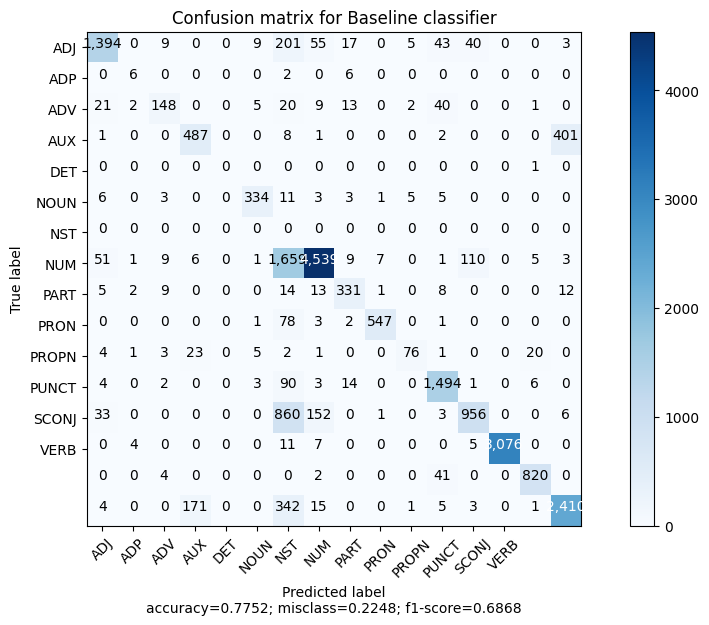

In [54]:
plot_confusion_matrix(f1_score(y_test, y_pred, average='macro'), cnf_matrix, target_names=classes, title='Confusion matrix for '+name+' classifier', normalize=False)

##Special preprocessing for NNs
##This is a very importand step for the whole process! So be careful, to rerun this step in case you change one of the following parameters:

*   MAX_SEQUENCE_LENGTH
*   BATCH_SIZE




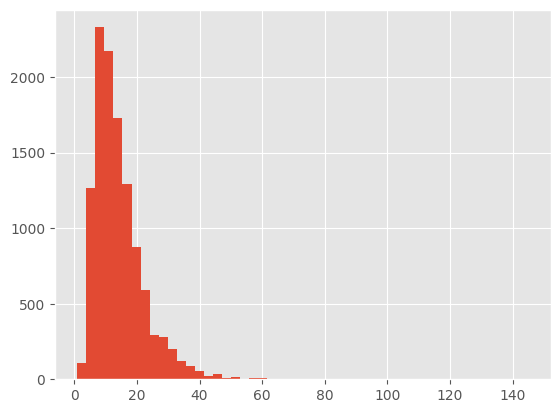

In [55]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.hist([len(s) for s in train_sentences], bins=50)
plt.show()

In [56]:
print('Max sentence length:',len(max(train_sentences+val_sentences, key=len)))

Max sentence length: 145


To improve speed we will use a MAX_SEQUENCE_LENGTH shorter than the max lengthed sentence. To avoid truncating sequences during padding we split our sentences to MAX_SEQUENCE_LENGTH and so the number of samples increases accordingly. For example, a sentence with length 120 splits in 2 sentences: 150=70+70+10

In [57]:
def  split(sentences, max):
    new=[]
    for data in sentences:
        new.append(([data[x:x+max] for x in range(0, len(data), max)]))
    new = [val for sublist in new for val in sublist]
    return new

In [58]:
train_sentences = split(train_sentences, MAX_SEQUENCE_LENGTH)
val_sentences = split(val_sentences, MAX_SEQUENCE_LENGTH)
test_sentences = split(test_sentences, MAX_SEQUENCE_LENGTH)

In [59]:
len(max(train_sentences+val_sentences, key=len))

70

For ELMo to work correctly, the number of samples must be divisible by the batch_size. So here we pad the samples until their number becomes divisible by the batch_size:

In [60]:
train_sentences = train_sentences+val_sentences

In [61]:
print('Number of samples before sample padding:',len(train_sentences))

Number of samples before sample padding: 13017


In [62]:
def elmo_pad(sentences):
    if len(sentences) % BATCH_SIZE !=0:
        pad_len = ((len(sentences)//BATCH_SIZE)+1)*BATCH_SIZE-len(sentences)
        return sentences.extend([[('-PAD-','-PAD-')]]*pad_len)

In [63]:
elmo_pad(train_sentences)
elmo_pad(test_sentences)
#elmo_pad(val_sentences)

Check the samples padding:

In [64]:
print('Number of samples after sample padding:',len(train_sentences))

Number of samples after sample padding: 13024


In [65]:
train_sentences[-5:]

[[('-PAD-', '-PAD-')],
 [('-PAD-', '-PAD-')],
 [('-PAD-', '-PAD-')],
 [('-PAD-', '-PAD-')],
 [('-PAD-', '-PAD-')]]

##Map and then pad the sentences to sequences of numbers (for terms and also for tags)

In [66]:
def transform(sentences):
    X, y, unk = numberize(sentences)
    print('sample X_train_numberised: ', X[0])
    print('sample y_train_numberised: ', y[0])
    print('Number of numberized sentences:', len(X))
    print('Number of unknown words:', len(unk))
    X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
    y = pad_sequences(y, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
    y = to_categorical(y, num_classes=n_tags)   
    return X, y

In [67]:
X_train, y_train = transform(train_sentences)

sample X_train_numberised:  [23704, 32831, 11566, 23863, 35061, 19678, 149]
sample y_train_numberised:  [11, 6, 6, 6, 1, 14, 12]
Number of numberized sentences: 13024
Number of unknown words: 0


In [68]:
X_test, y_test = transform(test_sentences)

sample X_train_numberised:  [25479, 38342, 27256, 1014, 1751, 37620, 1329, 30623, 36111, 28223, 21496, 7055, 15973, 17061, 38641, 4518, 9458, 38791, 149]
sample y_train_numberised:  [6, 10, 1, 6, 14, 1, 1, 6, 3, 10, 6, 6, 14, 9, 10, 8, 1, 14, 12]
Number of numberized sentences: 1504
Number of unknown words: 0


See a padded numberized sample:

In [69]:
X_train[0]

array([23704, 32831, 11566, 23863, 35061, 19678,   149,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0], dtype=int32)

In [70]:
y_train[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [71]:
print('Training samples have shape {} and training labels {}'.format(X_train.shape,y_train.shape))
print('Testing samples have shape {} and testing labels {}'.format(X_test.shape,y_test.shape))
#print('Validation samples have shape {} and validation labels {}'.format(X_val.shape,y_val.shape))
print('Word vectors have shape', embedding_matrix.shape)

Training samples have shape (13024, 70) and training labels (13024, 70, 15)
Testing samples have shape (1504, 70) and testing labels (1504, 70, 15)
Word vectors have shape (39716, 300)


##==========================================================================================

##1. CNN with pre-trained word embeddings

In [72]:
 def accuracy_masked_class(to_ignore=0):
    def accuracy_masked(y_true, y_pred):
        y_true_class = K.argmax(y_true, axis=-1)
        y_pred_class = K.argmax(y_pred, axis=-1)
 
        ignore_mask = K.cast(K.not_equal(y_true_class, to_ignore), 'int32')
        matches = K.cast(K.equal(y_true_class, y_pred_class), 'int32') * ignore_mask
        accuracy = K.sum(matches) / K.maximum(K.sum(ignore_mask), 1)
        return accuracy
    return accuracy_masked

In [73]:
def define_model(length, filters, vocab_size):
    seed = 0
    
    np.random.seed(seed)
    inputs = Input(shape=(length, ), dtype='int32')
    np.random.seed(seed)
    embedding = Embedding(input_dim=len(word2int),
                  output_dim=EMBEDDING_DIM,
                  weights=[embedding_matrix],
                  input_length=length,
                  trainable=True,
                  mask_zero=False
                 )(inputs)
    
 
    # channel 1
    np.random.seed(seed)
    channel_1 = Conv1D(filters=filters, kernel_size=2, padding='same')(embedding)
    #np.random.seed(seed)
    #channel_1 = add([embedding, channel_1])
    np.random.seed(seed)
    channel_1_2 = Conv1D(filters=filters, kernel_size=2, padding='same')(channel_1)
    #channel_1_3 = Conv1D(filters=filters, kernel_size=2, padding='same')(channel_1_2)
    np.random.seed(seed)
    channel_1 = add([channel_1, channel_1_2])
    np.random.seed(seed)
    channel_1 = Dropout(0.5)(channel_1) 

    # channel 2
    np.random.seed(seed)
    channel_2 = Conv1D(filters=filters, kernel_size=3, padding='same')(embedding)
    np.random.seed(seed)
    #channel_2 = add([embedding, channel_2])
    #np.random.seed(seed)
    channel_2_2 = Conv1D(filters=filters, kernel_size=3, padding='same')(channel_2)
    #channel_2_3 = Conv1D(filters=filters, kernel_size=3, padding='same')(channel_2_2)
    np.random.seed(seed)
    channel_2 = add([channel_2, channel_2_2])
    np.random.seed(seed)
    channel_2 = Dropout(0.5)(channel_2)  

    # channel 3
    np.random.seed(seed)
    channel_3 = Conv1D(filters=filters, kernel_size=4, padding='same')(embedding)
    np.random.seed(seed)
    #channel_3 = add([embedding, channel_3])
    #np.random.seed(seed)
    channel_3_2 = Conv1D(filters=filters, kernel_size=4, padding='same')(channel_3)
    #channe_3_3 = Conv1D(filters=filters, kernel_size=4, padding='same')(channel_3_2)
    np.random.seed(seed)
    channel_3 = add([channel_3, channel_3_2])
    np.random.seed(seed)
    channel_3 = Dropout(0.5)(channel_3) 

    np.random.seed(seed)    
    merged = concatenate([channel_1, channel_2, channel_3])
    np.random.seed(seed)    
    #merged = Dropout(0.2)(merged)
    
    np.random.seed(seed)
    output = Dense(n_tags, activation='softmax')(merged)  # softmax output layer   
    np.random.seed(seed)
    model = Model(inputs=inputs, outputs=output)
    np.random.seed(seed)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', accuracy_masked_class(0)])
    print(model.summary())
    return model

In [74]:
model = define_model(length=MAX_SEQUENCE_LENGTH, filters=100, vocab_size=len(word2int))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 70)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 70, 300)      11914800    ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 70, 100)      60100       ['embedding[0][0]']              
                                                                                                  
 conv1d_2 (Conv1D)              (None, 70, 100)      90100       ['embedding[0][0]']              
                                                                                              

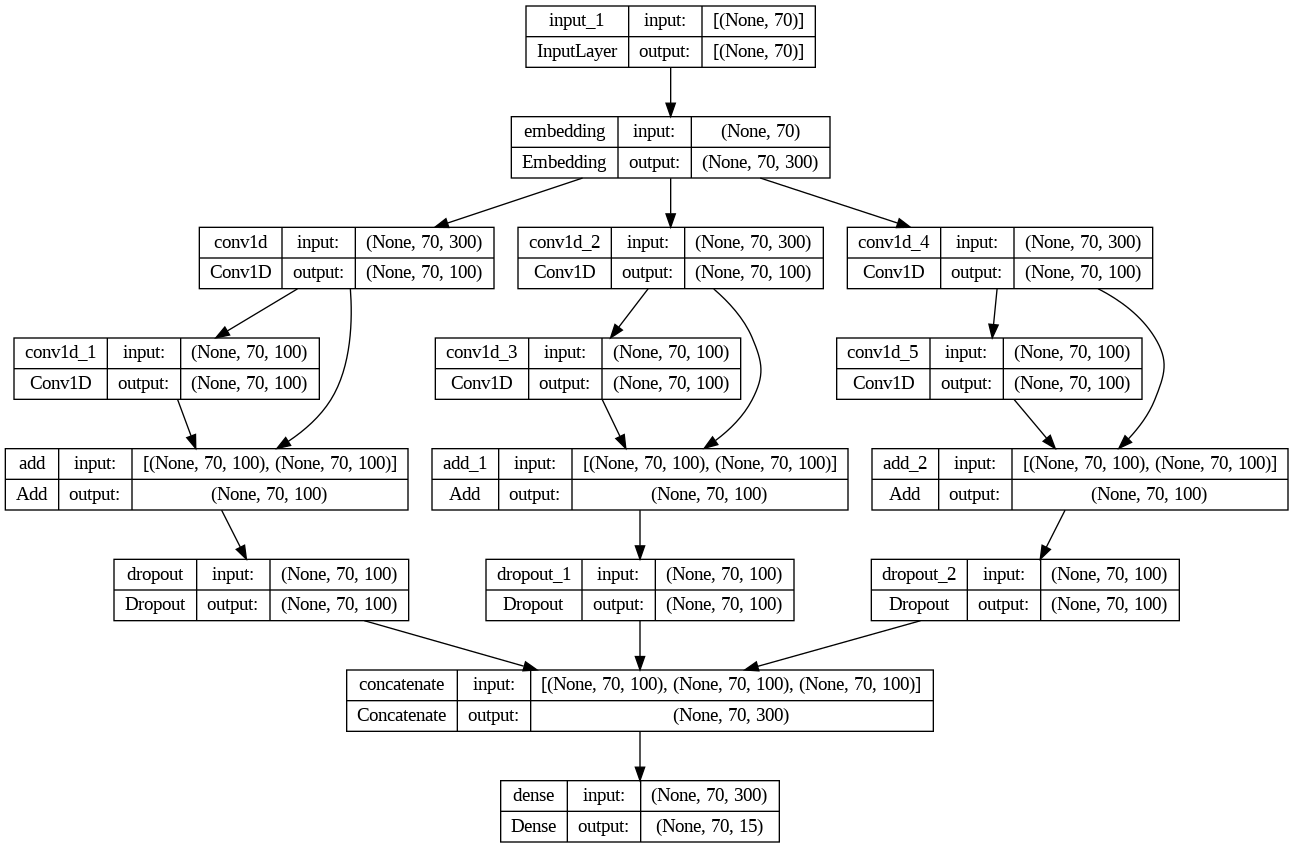

In [75]:
plot_model(model, to_file='model.png', show_shapes=True)
Image('model.png')

In [76]:
seed = 0
np.random.seed(seed)
t_ini = datetime.datetime.now()

cp = ModelCheckpoint(filepath="cnn_w2v_tagger.h5",
                     monitor='val_accuracy_masked',
                     save_best_only=True,
                     verbose=1)

early_stopping = EarlyStopping(monitor = 'val_accuracy_masked', patience = 5)


history = model.fit(X_train, y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,          
                    validation_data=(X_test, y_test),
                    verbose=1,
                    callbacks=[cp, early_stopping])

t_fin = datetime.datetime.now()
print('Training completed in {} seconds'.format((t_fin - t_ini).total_seconds()))

Epoch 1/10
406/407 [============================>.] - ETA: 0s - loss: 0.2018 - accuracy: 0.9367 - accuracy_masked: 0.6956
Epoch 1: val_accuracy_masked improved from -inf to 0.84124, saving model to cnn_w2v_tagger.h5
407/407 [==============================] - 57s 102ms/step - loss: 0.2016 - accuracy: 0.9367 - accuracy_masked: 0.6960 - val_loss: 0.1021 - val_accuracy: 0.9682 - val_accuracy_masked: 0.8412
Epoch 2/10
407/407 [==============================] - ETA: 0s - loss: 0.0573 - accuracy: 0.9825 - accuracy_masked: 0.9132
Epoch 2: val_accuracy_masked improved from 0.84124 to 0.86542, saving model to cnn_w2v_tagger.h5
407/407 [==============================] - 10s 23ms/step - loss: 0.0573 - accuracy: 0.9825 - accuracy_masked: 0.9132 - val_loss: 0.0920 - val_accuracy: 0.9731 - val_accuracy_masked: 0.8654
Epoch 3/10
405/407 [============================>.] - ETA: 0s - loss: 0.0249 - accuracy: 0.9924 - accuracy_masked: 0.9622
Epoch 3: val_accuracy_masked did not improve from 0.86542
407/40

In [78]:
from keras.models import load_model
model = load_model('cnn_w2v_tagger.h5', custom_objects={'accuracy_masked': accuracy_masked_class()})

In [79]:
y_pred = model.predict(X_test, verbose=1).argmax(-1)
y_true = y_test.argmax(-1)

47/47 [==============================] - 0s 3ms/step


In [80]:
y_pred[0]

array([11, 10,  1,  6, 14,  1,  1,  6,  3, 10,  6,  6, 14,  9, 10,  8,  6,
       14, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0])

In [81]:
y_true[0]

array([ 6, 10,  1,  6, 14,  1,  1,  6,  3, 10,  6,  6, 14,  9, 10,  8,  1,
       14, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0])

In [82]:
# Function to convert label ids to labels and use them for sklearn's reports
def y2label(zipped, mask=0):
    out_true = []
    out_pred = []
    for zip_i in zipped:
        a, b = tuple(zip_i)
        if a != mask: #Exclude -PAD- term
            out_true.append(int2tag[a])
            out_pred.append(int2tag[b])
    return out_true, out_pred

In [83]:
y_zipped = zip(y_true.flat, y_pred.flat)
y_true, y_pred = y2label(y_zipped)

In [84]:
len(y_true), len(y_pred)

(21436, 21436)

In [85]:
name='CNN-Word embeddings model'
print('\n--------- Result of {} -------\n'.format(name))
print(classification_report(y_true, y_pred, digits=4))


--------- Result of CNN-Word embeddings model -------

              precision    recall  f1-score   support

       -PAD-     0.0000    0.0000    0.0000         0
         ADJ     0.8227    0.7810    0.8013      1776
         ADP     0.3750    0.2143    0.2727        14
         ADV     0.6724    0.5977    0.6329       261
         AUX     0.8810    0.8967    0.8888       900
         DET     0.9061    0.8841    0.8950       371
        NOUN     0.8372    0.8828    0.8594      6401
         NST     0.8287    0.7468    0.7856       395
         NUM     0.9372    0.8734    0.9042       632
        PART     0.8165    0.6544    0.7265       136
        PRON     0.9081    0.9171    0.9126      1617
       PROPN     0.7196    0.6559    0.6863      2011
       PUNCT     0.9980    0.9894    0.9937      3103
       SCONJ     0.9627    0.9539    0.9583       867
        VERB     0.8723    0.8933    0.8827      2952

    accuracy                         0.8679     21436
   macro avg     0.7692 

In [86]:
print("Accuracy: {0:.4f}".format(accuracy_score(y_true, y_pred)))
print('f1-macro score: {0:.4f}'.format(f1_score(y_true, y_pred, average='macro')))

Accuracy: 0.8679
f1-macro score: 0.7467


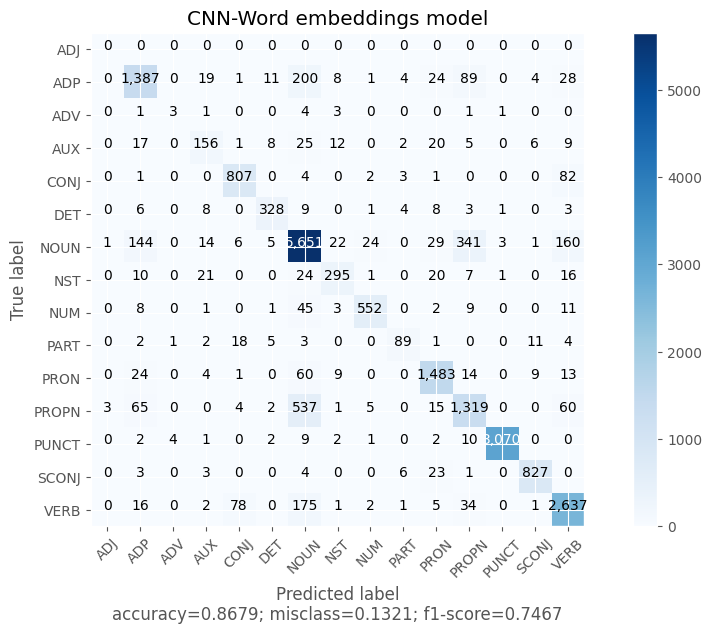

In [87]:
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(f1_score(y_true, y_pred, average='macro'), cnf_matrix, target_names=test_tags, title=name, normalize=False)

In [88]:
y_pred = model.predict(X_test).argmax(-1)
y_true = y_test.argmax(-1)

def make_prediction(i=10):
    note = ''
    sent = []
    print("{:15} ({:5}): {}".format("Word", "True", "Predicted"))
    print(35*'-')
    for w, true, pred in zip(X_test[i], y_true[i], y_pred[i]):
        if w!=0:
            if int2tag[true] != int2tag[pred]: note='<<--- Error!'
            print("{:15} ({:5}): {:5} {:5}".format(int2word[w], int2tag[true], int2tag[pred], note))
            note=''

47/47 [==============================] - 0s 3ms/step


In [89]:
make_prediction(i=1)

Word            (True ): Predicted
-----------------------------------
ही              (PRON ): PRON       
अल्कली          (NOUN ): NOUN       
प्रक्रिया       (NOUN ): NOUN       
त्याच्या        (PRON ): PRON       
निक्सतामालीझेशन (NOUN ): NOUN       
ह्या            (PRON ): PRON       
नावापासून       (NOUN ): NOUN       
उत्पन्न         (NOUN ): ADJ   <<--- Error!
झालेल्या        (VERB ): VERB       
नहुआत्ल         (NOUN ): NOUN       
(               (PUNCT): PUNCT      
अॅझ्टेक         (NOUN ): NOUN       
)               (PUNCT): PUNCT      
ह्या            (PRON ): PRON       
नावाने          (NOUN ): NOUN       
ओळखले           (VERB ): VERB       
जाते            (AUX  ): AUX        
.               (PUNCT): PUNCT      


##tag new user input sentence

In [90]:
sentence = nltk.word_tokenize('हा लेख पन्ना जिल्ह्याविषयी आहे. पन्ना शहराविषयीचा लेख येथे आहे. पन्ना जिल्हा भारतातील मध्य प्रदेश राज्यातील एक जिल्हा आहे.')

In [92]:
tokenized_sentence = []
unk = []
i=0
for word in sentence:
    if word in words:
        tokenized_sentence.append(word2int[word])
    else:
        tokenized_sentence.append(word2int['-UNK-'])
        i += 1
        unk.append(word)

#tokenized_sentence = [tokenized_sentence]
padded_tokenized_sentence = pad_sequences([tokenized_sentence], maxlen=MAX_SEQUENCE_LENGTH)

#print("{:15} ({:5}): {:5} {:5}".format(int2word[w], int2tag[true], int2tag[pred], note))

print('The sentence is:', sentence)
print('The tokenized sentence is:', tokenized_sentence)
print('The padded tokenized sentence is:', padded_tokenized_sentence)
print("There are {:} unknown words in sentence: {:}".format(i,(unk)))

The sentence is: ['हा', 'लेख', 'पन्ना', 'जिल्ह्याविषयी', 'आहे', '.', 'पन्ना', 'शहराविषयीचा', 'लेख', 'येथे', 'आहे', '.', 'पन्ना', 'जिल्हा', 'भारतातील', 'मध्य', 'प्रदेश', 'राज्यातील', 'एक', 'जिल्हा', 'आहे', '.']
The tokenized sentence is: [38342, 30501, 1, 1, 3087, 149, 1, 1, 30501, 28627, 3087, 149, 1, 12222, 24901, 25680, 21800, 29220, 4518, 12222, 3087, 149]
The padded tokenized sentence is: [[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
  38342 30501     1     1  3087   149     1     1 30501 28627  3087   149
      1 12222 24901 25680 21800 29220  4518 12222  3087   149]]
There are 5 unknown words in sentence: ['पन्ना', 'जिल्ह्याविषयी', 'पन्ना', 'शहराविषयीचा', 'पन्ना']


##MAke predictions

In [93]:
predictions = model.predict(padded_tokenized_sentence)

print("\n{:25}| {:15}: {:15}".format("Word in embedding layer", 'Initial word', "Predicted POS-tag"))
print(61*'-')
k = 0
for i, pred in enumerate(predictions[0]):
    try:
        if padded_tokenized_sentence[0][i]!=0:
            #print(i)
            #print(int2word[padded_tokenized_sentence[0][i]], ' : ', int2tag[np.argmax(pred)])
            print("{:25}| {:15}: {:5}".format(int2word[padded_tokenized_sentence[0][i]], sentence[k], int2tag[np.argmax(pred)]))
            k+=1
    except:
        pass

1/1 [==============================] - 0s 282ms/step

Word in embedding layer  | Initial word   : Predicted POS-tag
-------------------------------------------------------------
हा                       | हा             : PRON 
लेख                      | लेख            : NOUN 
-UNK-                    | पन्ना          : NOUN 
-UNK-                    | जिल्ह्याविषयी  : NOUN 
आहे                      | आहे            : VERB 
.                        | .              : PUNCT
-UNK-                    | पन्ना          : PROPN
-UNK-                    | शहराविषयीचा    : ADJ  
लेख                      | लेख            : NOUN 
येथे                     | येथे           : NST  
आहे                      | आहे            : VERB 
.                        | .              : PUNCT
-UNK-                    | पन्ना          : PROPN
जिल्हा                   | जिल्हा         : NOUN 
भारतातील                 | भारतातील       : PROPN
मध्य                     | मध्य           : ADJ  
प्रदेश                

##Frequent types of mistakes

In [94]:
def find_errors(X,y):
    error_counter = collections.Counter()
    support = 0
    y_pred = model.predict(X).argmax(-1)
    y_true = y_test.argmax(-1)
    for i in range(X.shape[0]):
        for w, true, pred in zip(X[i], y_true[i], y_pred[i]):
            if w!=0:
                support +=1
                if true != pred:
                    word = int2word[w]
                    error_counter[word] += 1
    return error_counter, support

In [95]:
errors, support = find_errors(X_test, y_test)
print('Total errors/Total words: {}/{} | Accuracy: {:.4}\n'.format(sum(errors.values()), support, 1-sum(errors.values())/support))
print('Most common errors:', errors.most_common(20))

47/47 [==============================] - 0s 3ms/step
Total errors/Total words: 2833/21437 | Accuracy: 0.8678

Most common errors: [('असे', 34), ('आहे', 25), ('नाही', 25), ('अशी', 19), ('स्वत:च्या', 14), ('सुमारे', 13), ('डॉ.', 12), ('मराठी', 11), ('असा', 10), ('वाजता', 10), ('अशा', 9), ('तर', 9), ('येथे', 8), ('राष्ट्रीय', 8), ('श्री', 8), ('खाद्ये', 7), ('ते', 7), ('सौ', 7), ('उत्पन्न', 6), ('पेल्लाग्र', 6)]


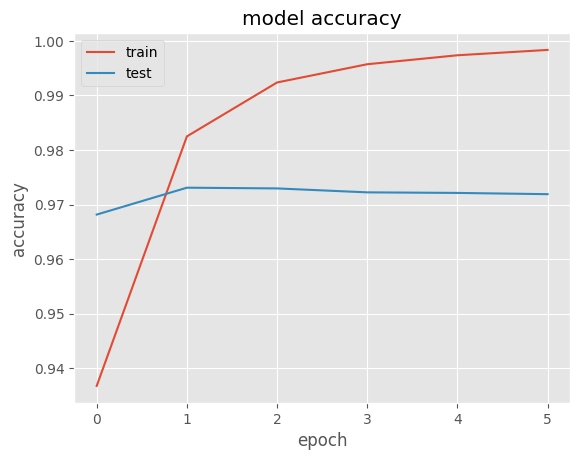

In [96]:
plot_acc()

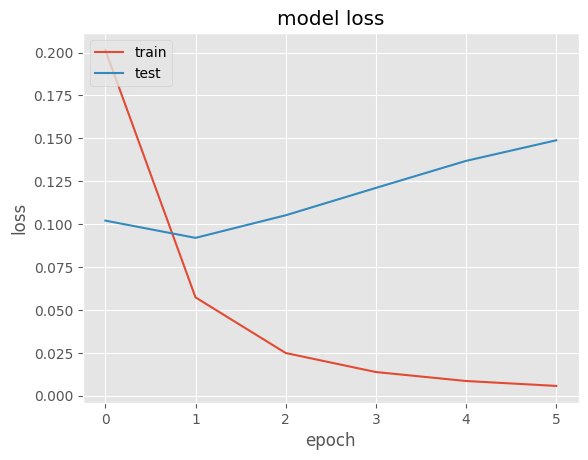

In [97]:
plot_loss()

##Making Wordnet definitions - dictionary

In [98]:
import re

In [99]:
def deleteLeadingZeros(inputString):
   # regex pattern for removing leading zeros from an input string
   regexPattern = "^0+(?!$)"
   # Replace the matched regex pattern with an empty string
   outputString = re.sub(regexPattern, "", inputString)
   # returning output string after removing leading 0s
   return outputString

In [100]:
# Initialize an empty dictionary
dictionary = {}

# Open the text file and read its contents line by line
with open("/content/drive/MyDrive/MArathi_data/data.txt", "r", encoding = 'utf-8') as f:
    for line in f:
        # Split the line into serial number and value
        line = line.strip()  # Remove any leading/trailing whitespace
        regexPattern = "^0+(?!$)"
        line = re.sub(regexPattern, "", line)
        serial_number, value = line.split(" ", 1)
        #serial_number = int(serial_number)  # Convert the serial number to an integer

        # Add the key-value pair to the dictionary
        dictionary[serial_number] = value

In [101]:
for n in dictionary.keys():
    # Remove numbers from the line using regular expressions
    line = dictionary.get(n)
    cleaned_line = re.sub(r'\d+', '', line)

    # Remove unnecessary spaces from the line
    cleaned_line = ' '.join(cleaned_line.strip().split())

    # Add the cleaned line to the list of cleaned lines
    dictionary.update({n:cleaned_line})

In [102]:
count = 0
for n in dictionary.keys():
  count+=1
  if count<5:
    print(n, dictionary.get(n))
  else:
    break

1 अजन्मा | ज्यास जन्म नाही असा:"ईश्वर अजन्मा आहे"
2 अशुभ:अमंगळ | शुभ नाही असा:"या योगामूळे कुंडलीतील इतर अशुभ योगांचा नाश होतो."
3 अप्रविष्ट | ज्याने प्रवेश केला नाही असा:"अप्रविष्ट व्यक्तींना ताबडतोब आत प्रवेश करू द्या."
4 पुण्यभूमी:पवित्रभूमी:पुण्यस्थान:पवित्रस्थान:पावनस्थान | पवित्र मानले गेलेले स्थान:"हिंदूंसाठी काशी ही पुण्यभूमी आहे."


##Synsets

In [103]:
!pip install --upgrade pyiwn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [104]:
import pyiwn

[██████████████████████████████████████████████████]


Marathi synset object creation

In [105]:
iwn = pyiwn.IndoWordNet(lang=pyiwn.Language.MARATHI)

In [106]:
list(map(str, pyiwn.PosTag))

['PosTag.NOUN', 'PosTag.VERB', 'PosTag.ADVERB', 'PosTag.ADJECTIVE']

In [108]:
synsets = iwn.all_synsets()
print(len(synsets))

32200


In [109]:
syn = synsets[:5]
syn = str(synsets[:5])
syn = list(syn.split(","))

In [110]:
import string
idx = []
printable_chars = string.printable
for line in syn:
  cleaned_text = "".join([char for char in line if char in printable_chars and char not in string.whitespace])
  n = re.findall('\d+', cleaned_text)
  idx.append(n)

In [111]:
print(idx)

[['5'], ['1'], ['7'], ['2'], ['10']]


Lookup

In [112]:
for n in idx:
  print(n, dictionary.get(n[0]))

['5'] शिवालय:शिवमंदिर | जिथे शंकराच्या पिंडीची स्थापना केली असून त्याची पूजा होते ती जागा:"ती दर सोमवारी शिवालयात जाते."
['1'] अजन्मा | ज्यास जन्म नाही असा:"ईश्वर अजन्मा आहे"
['7'] आलेला:आगत | दाखल झालेला:"आलेल्या पाहुण्यांचे स्वागत आहे."
['2'] अशुभ:अमंगळ | शुभ नाही असा:"या योगामूळे कुंडलीतील इतर अशुभ योगांचा नाश होतो."
['10'] उत्पादित:उत्पन्न | ज्याची उत्पत्ति झाली आहे असा:"आसाममध्ये उत्पादित चहा जगभर प्रसिद्ध आहे."


##FInal

In [141]:
sentence = nltk.word_tokenize(input())

दुकानात काही लोक काम करत असतात आणि कोपऱ्यात एक कुत्राही बसलेलं असते


In [160]:
key = input()

लोक


In [142]:
tokenized_sentence = []
unk = []
i=0
for word in sentence:
    if word in words:
        tokenized_sentence.append(word2int[word])
    else:
        tokenized_sentence.append(word2int['-UNK-'])
        i += 1
        unk.append(word)

#tokenized_sentence = [tokenized_sentence]
padded_tokenized_sentence = pad_sequences([tokenized_sentence], maxlen=MAX_SEQUENCE_LENGTH)

#print("{:15} ({:5}): {:5} {:5}".format(int2word[w], int2tag[true], int2tag[pred], note))

print('The sentence is:', sentence)
print('The tokenized sentence is:', tokenized_sentence)
print('The padded tokenized sentence is:', padded_tokenized_sentence)
print("There are {:} unknown words in sentence: {:}".format(i,(unk)))

The sentence is: ['दुकानात', 'काही', 'लोक', 'काम', 'करत', 'असतात', 'आणि', 'कोपऱ्यात', 'एक', 'कुत्राही', 'बसलेलं', 'असते']
The tokenized sentence is: [16046, 6675, 30568, 6172, 5519, 1729, 2318, 7693, 4518, 1, 1, 1735]
The padded tokenized sentence is: [[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0 16046  6675
  30568  6172  5519  1729  2318  7693  4518     1     1  1735]]
There are 2 unknown words in sentence: ['कुत्राही', 'बसलेलं']


In [143]:
predictions = model.predict(padded_tokenized_sentence)

print("\n{:25}| {:15}: {:15}".format("Word in embedding layer", 'Initial word', "Predicted POS-tag"))
print(61*'-')
k = 0
for i, pred in enumerate(predictions[0]):
    try:
        if padded_tokenized_sentence[0][i]!=0:
            #print(i)
            #print(int2word[padded_tokenized_sentence[0][i]], ' : ', int2tag[np.argmax(pred)])
            print("{:25}| {:15}: {:5}".format(int2word[padded_tokenized_sentence[0][i]], sentence[k], int2tag[np.argmax(pred)]))
            k+=1
    except:
        pass

1/1 [==============================] - 0s 22ms/step

Word in embedding layer  | Initial word   : Predicted POS-tag
-------------------------------------------------------------
दुकानात                  | दुकानात        : NOUN 
काही                     | काही           : DET  
लोक                      | लोक            : NOUN 
काम                      | काम            : NOUN 
करत                      | करत            : VERB 
असतात                    | असतात          : AUX  
आणि                      | आणि            : SCONJ
कोपऱ्यात                 | कोपऱ्यात       : NOUN 
एक                       | एक             : NUM  
-UNK-                    | कुत्राही       : NOUN 
-UNK-                    | बसलेलं         : NOUN 
असते                     | असते           : VERB 


In [161]:
wordid=0
for w in sentence:
  wordid+=1
  if w == key:
    print(wordid)
    break
  else:
    continue

3


In [162]:
tags = []
for tag in predictions[0]:
  T=[]
  T.append(int2tag[np.argmax(tag)])
  for t in T:
    if t != "-PAD-":
      tags.append(t)
    else:
      continue

In [163]:
TAG = tags[wordid-1]

In [164]:
TAG

'NOUN'

In [165]:
def get_synsets(word, tag):
  j = []
  if tag == "NOUN":
    j.append(str(iwn.synsets(word, pos=pyiwn.PosTag.NOUN)))
    
  elif tag == "ADJECTIVE":
  #all_synsets = iwn.synsets(word, pos=pyiwn.PosTag.ADJECTIVE)
    j.append(str(iwn.synsets(word, pos=pyiwn.PosTag.ADJECTIVE)))
    
  elif tag == "ADVERB":
  #all_synsets = iwn.synsets(word, pos=pyiwn.PosTag.ADVERB)
    j.append(str(iwn.synsets(word, pos=pyiwn.PosTag.ADVERB)))
    
  else:
  #all_synsets = iwn.synsets(word, pos=pyiwn.PosTag.VERB)
    j.append(str(iwn.synsets(word, pos=pyiwn.PosTag.VERB)))
  


  if len(j) == 0:
      print("The list is empty.")
  else:
      print("The list is not empty.")


  all_synsets=[]
  for i in j:
    #for k in i:
    temp = i.split(",")
    all_synsets.append(temp)
  
  return all_synsets

#Lookup

In [166]:
def get_index(synsets):
  idx = []
  
  #index idendification for lookup
  printable_chars = string.printable
  
  for line in synsets[0]:
    cleaned_text = "".join([char for char in line if char in printable_chars and char not in string.whitespace])
    n = re.findall('\d+', cleaned_text)
    idx.append(n)

  #returning the calculated results
  return idx

##get synsets

In [167]:
synsets = get_synsets(key,TAG)

The list is not empty.


In [168]:
print(synsets)

[["[Synset('लोक.noun.189')", " Synset('प्रजा.noun.1722')", " Synset('जग.noun.5461')", " Synset('वर्ग.noun.28474')]"]]


In [169]:
idx = get_index(synsets)
print(idx)

[['189'], ['1722'], ['5461'], ['28474']]


##POS

In [170]:
predictions = model.predict(padded_tokenized_sentence)

print("\n{:25}| {:15}: {:15}".format("Word in embedding layer", 'Initial word', "Predicted POS-tag"))
print(61*'-')
k = 0
for i, pred in enumerate(predictions[0]):
    try:
        if padded_tokenized_sentence[0][i]!=0:
            #print(i)
            #print(int2word[padded_tokenized_sentence[0][i]], ' : ', int2tag[np.argmax(pred)])
            print("{:25}| {:15}: {:5}".format(int2word[padded_tokenized_sentence[0][i]], sentence[k], int2tag[np.argmax(pred)]))
            k+=1
    except:
        pass

1/1 [==============================] - 0s 20ms/step

Word in embedding layer  | Initial word   : Predicted POS-tag
-------------------------------------------------------------
दुकानात                  | दुकानात        : NOUN 
काही                     | काही           : DET  
लोक                      | लोक            : NOUN 
काम                      | काम            : NOUN 
करत                      | करत            : VERB 
असतात                    | असतात          : AUX  
आणि                      | आणि            : SCONJ
कोपऱ्यात                 | कोपऱ्यात       : NOUN 
एक                       | एक             : NUM  
-UNK-                    | कुत्राही       : NOUN 
-UNK-                    | बसलेलं         : NOUN 
असते                     | असते           : VERB 


In [171]:
idx

[['189'], ['1722'], ['5461'], ['28474']]

In [172]:
ambiguity = iwn.synsets(key)

In [173]:
ambiguity = str(ambiguity)


In [174]:
ambiguity = re.findall(r"\w+\.(noun|verb|adverb|adjective)\.\d+", ambiguity)

# Remove duplicates from the list
ambiguity = list(set(ambiguity))

In [176]:
print("lets see if the key input in this sentence is ambiguous or not?")
if len(ambiguity) == 1:
  print("the required key is not ambiguos but can have different ways of representation please run the next cell to know more")
  print()
  print(ambiguity,"only have one POS tag related to this key: ", key)
else:
  print("the quried key is ambiguos and can appear or show multiple meaning and ways of representations please run the next cell to know more")
  print()
  print(ambiguity,"as you can see the key has multiple POS tags related to it and can change the meaning of the entire sentence if not tagged correctly: ", key)

lets see if the key input in this sentence is ambiguous or not?
the quried key is ambiguos and can appear or show multiple meaning and ways of representations please run the next cell to know more

['noun', 'adjective'] as you can see the key has multiple POS tags related to it and can change the meaning of the entire sentence if not tagged correctly:  लोक


In [177]:

print(sentence)
print()
print("Related synsets = ", "\n", synsets)
print()
print("Related indexes = ", "\n", idx)
print()
count = 0
for sublist in idx:
    if count == 2:
        break
    for i in range(1):
        print("Word ID", sublist," - ", dictionary.get(sublist[0]))
    count += 1

['दुकानात', 'काही', 'लोक', 'काम', 'करत', 'असतात', 'आणि', 'कोपऱ्यात', 'एक', 'कुत्राही', 'बसलेलं', 'असते']

Related synsets =  
 [["[Synset('लोक.noun.189')", " Synset('प्रजा.noun.1722')", " Synset('जग.noun.5461')", " Synset('वर्ग.noun.28474')]"]]

Related indexes =  
 [['189'], ['1722'], ['5461'], ['28474']]

Word ID ['189']  -  लोक:जनता:जन | एकाहून अधिक व्यक्ती:"नेत्याचे भाषण ऐकण्यासाठी बरेच लोक जमले होते"
Word ID ['1722']  -  प्रजा:रयत:लोक:जनता:प्रजाजन:जनसामान्य | एखाद्या राजा वा शासनाच्या आधिपत्याखाली असलेला किंवा त्याच्या राज्यात राहणारा व्यक्तीसमुह:"रामराज्यात प्रजा सुखी होती."


In [ ]:
text1 = "दुकानात काही लोक काम करत असतात आणि कोपऱ्यात एक कुत्राही बसलेलं असते"

In [ ]:
key2 = "बसलेलं"

In [ ]:
iwn.synsets(key2)